import libraries

In [32]:
import pandas as pd
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(1234)

Task 1

In [33]:
#Import public Covid cases dataset taken from CDC site
#Dataset can be found at https://healthdata.gov/dataset/united-states-covid-19-cases-and-deaths-state-over-time
cdc_cases_df=pd.read_csv("United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv",sep=',')

#Select relevant columns
cdc_cases_df=cdc_cases_df[['submission_date','state','tot_cases','new_case']]

#Sort CDC dataset based on state then date
cdc_cases_df=cdc_cases_df.sort_values(by=['state','submission_date'])

#Import Search Trends dataset
search_trends_df=pd.read_csv('2020_US_weekly_symptoms_dataset.csv',sep = ',',low_memory=False)

#Align region formats in both datasets Search Trends has US-AK for Alaska and CDC has AK for Alaska
search_trends_df['open_covid_region_code']=search_trends_df['open_covid_region_code'].str[3:]

#Isolate data pertaining to US States in Search Trends dataset
cdc_cases_df=cdc_cases_df[cdc_cases_df['state'].isin(search_trends_df['open_covid_region_code'].unique())]

#Change date format in CDC dataset from MM/DD/YYYY to YYYY-MM-DD
cdc_cases_df['submission_date']=pd.to_datetime(cdc_cases_df.submission_date).dt.strftime('%Y-%m-%d')

#Remove data before 2020-03-09 in the Symptom Searches dataset in order to merge both datasets
#Note that 2020-03-09 is the first Monday which has data in both datasets for the US regions
search_trends_df=search_trends_df[search_trends_df['date'] >= "2020-03-09"]

#Remove data before 2020-03-09 in the CDC Covid cases dataset in order to merge both datasets
#Note that 2020-03-09 is the first Monday which has data in both datasets for the US regions
cdc_cases_df=cdc_cases_df[cdc_cases_df['submission_date'] >= "2020-03-09"]

#Remove data after 2020-09-27 (last Sunday in both datasets) from both datasets
#in order to merge both datasets on a weekly basis
cdc_cases_df=cdc_cases_df[cdc_cases_df['submission_date'] <= "2020-09-27"]
search_trends_df=search_trends_df[search_trends_df['date'] <= "2020-09-27"]

#Delete columns from CDC and Search Trends data that contain only NaN values
cdc_cases_df=cdc_cases_df.dropna(how='all', axis=1)
search_trends_df=search_trends_df.dropna(how='all', axis=1)

#Isolate data for each Sunday of week (weekly cumulative total of Covid cases is at the end of the week)
sunday_data=cdc_cases_df[pd.to_datetime(cdc_cases_df['submission_date']).dt.dayofweek==6].copy(deep=True)

#Replace daily data in CDC dataset with the Monday date of the corresponding week
cdc_cases_df['submission_date']=pd.to_datetime(cdc_cases_df['submission_date']) - pd.to_timedelta(pd.to_datetime(cdc_cases_df['submission_date']).dt.dayofweek, unit='d')

#Add up daily Covid cases to get weekly count
sum_weekly_data=cdc_cases_df.groupby(['state','submission_date']).sum().reset_index()['new_case']
sunday_data=sunday_data.reset_index().assign(new_case=sum_weekly_data)
sunday_data['submission_date']=pd.to_datetime(sunday_data['submission_date']) - pd.to_timedelta(pd.to_datetime(sunday_data['submission_date']).dt.dayofweek, unit='d')
cdc_cases_df=sunday_data

#Merge data
merged_data_df = pd.concat([cdc_cases_df.reset_index(drop=True),search_trends_df.reset_index(drop=True)],axis=1)

#Delete duplicate columns and unnecessary columns
merged_data_df=merged_data_df.drop(['index','tot_cases','open_covid_region_code','country_region_code','country_region','sub_region_1','sub_region_1_code','date'], axis=1).rename(columns={"submission_date": "date"})

#Remove columns with more than 35% NaN values
threshold=0.35
missings = merged_data_df.isna().sum()/merged_data_df.shape[0]
deleting = merged_data_df.columns[missings>threshold]
cols = merged_data_df.columns[missings<=threshold]
merged_data_df.drop(deleting,axis=1,inplace=True)

symptoms = merged_data_df.columns[3:]
filldf = pd.DataFrame(data=np.zeros(merged_data_df.shape),columns=merged_data_df.columns)
themin = np.inf

for state in merged_data_df['state'].unique():
    location = merged_data_df['state']==state, symptoms
    k = merged_data_df.loc[location]
    #Minimum accross all symptom trends in specific US region
    min2 = np.min(np.min(k))
    if min2<themin:
        #Minimum accross all symptom trends and US regions
        themin = min2
    filldf.loc[location] = min2

#Fill NaN values in each column with column minimum
merged_data_df.fillna(filldf,inplace=True)
if merged_data_df.isnull().values.any():
    merged_data_df.fillna(themin,inplace=True)

#Replace column with abbreviated state names (ex: NY, AK) with full name (ex: New York, Alaska)
state_acronym_to_name={'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California','CO': 'Colorado','CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina','ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}
merged_data_df=merged_data_df.replace({'state': state_acronym_to_name})

#We will take into account internet population
#because the data only makes sense in one state, it is comparable. If we want to 
#compare between states, we need to scale them.
internet_usage_df = pd.read_excel('internet_usage.xlsx')
internet_usage_df.drop(['total population', 'percentage of internet users'],axis=1, inplace=True)
states = merged_data_df['state'].unique()
internet_usage_df.rename(columns={ internet_usage_df.columns[0]: "states" }, inplace = True)
truncated_internet_usage_df = internet_usage_df.loc[internet_usage_df['states'].isin(states)]
cols = merged_data_df.columns[3:]
for state in truncated_internet_usage_df['states']:
    merged_data_df.loc[merged_data_df['state']==state, cols] *= float(truncated_internet_usage_df[truncated_internet_usage_df['states']==state]['No. internet users']/100000)

#Create new dataset that contains hospitalized_new data, new_cases data and search trends data
merged_hospitalization_search_trends=pd.read_csv("merged_data.csv",sep=',')
merged_data_df=merged_data_df[merged_data_df['state'].isin(merged_hospitalization_search_trends['region_name'].unique())].reset_index()
merged_data_df.insert(1,'hospitalized_new',merged_hospitalization_search_trends['hospitalized_new'])

#Swap column order and rename "state" column "region_name"
cols=merged_data_df.columns.tolist()
cols=cols[3:4]+cols[2:3]+cols[1:2]+cols[4:]
merged_data_df=merged_data_df[cols].rename(columns={"state": "region_name"})

#Generate CSV file from dataframe
merged_data_df.to_csv('extra_merged_data.csv', encoding='utf-8')

#print(merged_data_df)

we will mostly use KNN and decision tree code provided in class, but do some modification where we need regression instead of classification

In [34]:
#distance function
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:
    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x,y):
        self.x = x
        self.y = y
        return self
    
    def predict(self, x_test):
        num_test = x_test.shape[0]
        self.x = np.array(self.x, dtype=np.float64)
        x_test = np.array(x_test, dtype=np.float64)
        
        #create distance between each x_test and self.x
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:]) # num_test x num_train
        y_res = np.zeros((x_test.shape[0], self.K), dtype=np.float64)
        knns = np.zeros((x_test.shape[0], self.K), dtype=int)
        for i in range(num_test):
            #find the shortest distance
            knns[i,:] = np.argsort(distances[i])[:self.K]
            
            #find the labels of those shortest distances
            y_res[i,:] = self.y[knns[i,:]].T.ravel()
        return y_res, knns

#now begins for decision tree class
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_value = None
        if parent:
            #copy all things from parent
            self.depth = parent.depth + 1
            self.data = parent.data
            self.labels = parent.labels


def greedy_test(node, cost_fn):
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    data_sorted = np.sort(node.data[node.data_indices],0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    
    #for each features
    for f in range(num_features):
        data_f = node.data[node.data_indices, f]
        #for each test value in the feature
        for test in test_candidates[:,f]:
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #recursive call for left and right
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

#we need to create functions for cost function.
def mean_square(labels):
    mean = labels.mean()
    return np.sum((labels-mean)**2)/labels.size
def mean_absolute(labels):
    mean = labels.mean()
    return np.sum(abs(labels-mean))/labels.size

class DecisionTree:
    def __init__(self, max_depth=5, cost_fn=mean_square, min_leaf_instances=1):
        self.max_depth = max_depth
        self.root = None
        self.cost_fn = cost_fn
        self.min_leaf_instances = min_leaf_instances
        
    def fit(self, data, labels):
        pass
    
    def predict(self, data_test):
        pass
    
    
def fit(self, data, labels):
    #take in data and labels
    self.data = data
    self.labels = labels
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.depth = 0
    self._fit_tree(self.root)
    return self

def fit_tree(self, node):
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    if np.isinf(cost):
        return
    
    test = node.data[node.data_indices,split_feature] <= split_value
    node.split_feature = split_feature
    node.split_value = split_value
    #recursively construct the tree
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    self._fit_tree(left)
    self._fit_tree(right)
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = fit_tree


def predict(self, data_test):
    predictions = np.zeros((data_test.shape[0],1))
    for n, x in enumerate(data_test):
        node = self.root
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
                
        #find the mean of the labels avaliable
        predictions[n,0] = node.labels[node.data_indices].mean()
    return predictions 
DecisionTree.predict = predict

each time we report validation error, we report one single value(accuracy) for any given x_train, y_train, x_test, y_test and hyperparameter of model. We make functions of them so we can reuse them. (We will compare our hand-implemented model before, and the built-in sklearn model)

In [35]:
def validation_error_KNN_our(x_train, y_train, x_test, y_test, K):
    #instantiate model
    model = KNN(K, dist_fn=euclidean)
    #train the model and predicts
    y_prob, knns = model.fit(x_train, y_train).predict(x_test)
    #get prediction for each input
    y_pred = np.mean(y_prob,1) #axis=1
    #calculate mean of square errors
    accuracy1 = np.sum((y_pred - y_test)**2)/y_test.shape[0]
    return accuracy1

def validation_error_KNN_built_in(x_train, y_train, x_test, y_test, K):
    #instantiate model
    neigh = KNeighborsClassifier(n_neighbors=K)
    a = y_train.T.ravel()
    #fit the model
    neigh.fit(x_train.tolist(), a.tolist())
    #get prediction
    pred = neigh.predict(x_test.tolist())
    #get accuracy, mean of square errors.
    accuracy2 = np.sum((pred - y_test)**2)/y_test.shape[0]
    return accuracy2

def validation_error_decision_tree_our(x_train, y_train, x_test, y_test, depth):
    #instantiate model
    tree = DecisionTree(max_depth=depth)
    #train model and make predictions
    y_pred = tree.fit(x_train, y_train).predict(x_test)
    #report mean of square errors
    accuracy1 = np.sum((y_pred - y_test)**2)/y_test.shape[0]
    return accuracy1

def validation_error_decision_tree_built_in(x_train, y_train, x_test, y_test, depth):
    X = x_train.tolist()
    y = y_train.T.ravel().tolist()
    #instantiate model
    clf = DecisionTreeRegressor(max_depth=depth, random_state=5)
    #fit the model
    clf.fit(X, y)
    #make predictions
    y_pred = clf.predict(x_test.tolist())
    #report mean of square errors
    accuracy2 = np.sum((y_pred.ravel() - y_test.T.ravel())**2)/y_test.shape[0]
    return accuracy2


Either we want to split in date or region, we separate data into two parts, one is training data, and the other one is test data; for each hyperparameter, we report an MSE between prediction and y_test. For convinience, we return the list of MSE

In [36]:
def error_date(dataf,validating_error_type, n=30):
    #all data before 2020-08-10 are for testing
    train = (dataf[dataf['date']<='2020-08-10']).to_numpy()
    #all data after 2020-08-10 is for testing
    test = (dataf[dataf['date']>'2020-08-10']).to_numpy()
    #split each part to data and labels
    x_train, y_train = (train[:,2:])[:,1:], (train[:,2:])[:,:1]
    x_test, y_test = (test[:,2:])[:,1:], (test[:,2:])[:,:1]
    errors_date = []
    for K in range(2,n):
        #report each error for differen hyperparameters
        accuracy1 = validating_error_type(x_train, y_train, x_test, y_test, K)
        errors_date.append(accuracy1)
    #return all errors
    return errors_date


def datalistfn(a,L, dataf):
    cols = dataf.columns
    n = a.shape[0]
    parts = {}
    for i in range(L):
        #each part is a tuple, start index and end index
        parts[i] = (round(i*n/L), round((i+1)*n/L))
    #we will make a datalist of length L, each is a slice of the dataf
    datalist = []
    for i in parts:
        #make an empty dataframe
        d = pd.DataFrame(0, index=np.arange(0), columns=cols)
        for j in range(parts[i][0], parts[i][1]):
            #it is based on region_name, so select everything correspond to this region_name
            x1 = dataf[dataf['region_name']==a[j]]
            d = np.concatenate((d, x1))
        datalist.append(d)
    #return the datalist for merging L-1 of them
    return datalist

def x_ys(datalist,i,L,columns1):
    test = datalist[i]
    rest = list(range(L))
    rest.remove(i)
    #the rest is the recipe for merging training set, just except for the test
    #initialize train as an empty dataset
    train = pd.DataFrame(0, index=np.arange(0), columns=columns1)
    for j in rest:
        train = np.concatenate((train, datalist[j]))
    #so train and test are all ready
    x_train, y_train = (train[:,2:])[:,1:], (train[:,2:])[:,:1]
    x_test, y_test = (test[:,2:])[:,1:], (test[:,2:])[:,:1]
    return x_train, y_train, x_test, y_test

def error_region(dataf,validating_error_type, n=30):
    #all states avaliable
    a = dataf['region_name'].unique()
    L=5
    errors_region = []
    datalist = datalistfn(a,L,dataf)
    #for each fold
    for i in range(L):
        x_train, y_train, x_test, y_test = x_ys(datalist,i,L,dataf.columns)
        temp_error = []
        for K in range(2,n):
            #get error for each fold and hyperparameter
            accuracy1 = validating_error_type(x_train, y_train, x_test, y_test, K)
            temp_error.append(accuracy1)
        errors_region.append(temp_error)
    #return all errors
    return errors_region

Now we are ready for the tools we will use during the analysis

In [37]:
rawdf = merged_data_df.copy(deep=True)

Comparing result deciding whether to normalize or standardize the data, or is a shift is favorable. Since we see that raw data and shifted data gives us the best result, we will use raw data and shift it(as we do in the bottom part in this section) 

In [38]:
def shift_(inputdf, shift, shift_colall):
    list0 = [0]
    #every state avaliable
    states = inputdf['region_name'].unique()
    for i in states:
        #first shift shift_col feature
        shift_col = shift_colall[0]
        
        #all data related to the state
        instate = inputdf[inputdf['region_name']==i]
        
        #index of the records of instate, and we only need the ones start from shift
        indexes = inputdf.index[inputdf['region_name'] == i][shift:]
        
        #(get the column that we want to shift, and get only the useful data*not the first several one
        newlist = instate[shift_col][indexes]
        
        #restore the index
        newlist.index = indexes-shift
        
        #but the df still has problem, at least we cannot put it back now. We need to make them compatible with 0
        shiftlist = pd.Series(list0*shift, dtype=np.float64)
        
        #append the newlist so it can be put back
        newlist = newlist.append(pd.Series(shiftlist), ignore_index=True)
        
        #restore index so that we can put it back in correct position
        newlist.index = newlist.index + (indexes[0]-shift)
        
        #put the list back to the whole part of original datafram by loc method
        inputdf.loc[inputdf[inputdf['region_name']==i][shift_col].index, shift_col] = newlist
        
        #do the same thing for the other feature(we potentially have a loop, but we are sure we will only shift two values)
        shift_col = shift_colall[1]
        instate = inputdf[inputdf['region_name']==i]
        indexes = inputdf.index[inputdf['region_name'] == i][shift:]
        newlist = instate[shift_col][indexes]
        newlist.index = indexes-shift
        shiftlist = pd.Series(list0*shift, dtype=np.float64)
        newlist = newlist.append(pd.Series(shiftlist), ignore_index=True)
        newlist.index = newlist.index + (indexes[0]-shift)
        inputdf.loc[inputdf[inputdf['region_name']==i][shift_col].index, shift_col] = newlist
        
        #drop the last two rows for each part of a state, because they lack important features, so they are discarded
        inputdf.drop(indexes[-1-shift : -1]+1, inplace=True)
    return inputdf

Now we are ready to shift two values for specific amount. Let's find out which shift and option(raw, normalize or standardize) is the best option. We see there is a three metrics increases for shift 3, and the increased performance of KNN may be due to less data, because it has a large error. One can also regard shift = 4 as a good option; here we do not do it. We will go with shift = 2, because it does not eliminate too much test data

In [39]:
print("best MSE's: ")
print("     df1             df2             df3     ")
#let's try to shift from 0 to 5
for k in range(6):   #for each shift
    tempdf = rawdf.copy(deep=True)
    print('shift = %d' % (k))
    
    #shift those two columns
    df = shift_(tempdf, k, ['hospitalized_new', 'new_case'])

    #use df as a base, try to normalize it to see the effect
    df1 = df.copy(deep=True)
    features = df1.columns[3:]
    for i in features:
        min1 = (df1[i]).min()
        dif = (df1[i]).max() - min1
        df1[i] = (df1[i]-min1)/dif
    
    #use df as a base, try to standardize it to see the effect
    df2 = df.copy(deep=True)
    features = df2.columns[3:]
    for i in features:
        mean = (df2[i]).mean()
        std = (df2[i]).std()
        df2[i] = (df2[i]-mean)/std
    
    #one type of error for all three df's
    error1 = error_date(df,validation_error_KNN_our,n=15)
    error2 = error_date(df1,validation_error_KNN_our,n=15)
    error3 = error_date(df2,validation_error_KNN_our,n=15)
    
    #report the result of all three df's (by their min)
    print("%f \t%f \t%f" % (np.min(error1), np.min(error2), np.min(error3)))
    
    #same thing for decision_tree
    error1 = error_date(df,validation_error_decision_tree_our,n=6)
    error2 = error_date(df1,validation_error_decision_tree_our,n=6)
    error3 = error_date(df2,validation_error_decision_tree_our,n=6)
    print("%f \t%f \t%f" % (np.min(error1), np.min(error2), np.min(error3)))
    print()
    
    #same thing for split in region
    error1 = error_region(df,validation_error_KNN_our,n=15)
    error2 = error_region(df1,validation_error_KNN_our,n=15)
    error3 = error_region(df2,validation_error_KNN_our,n=15)
    print("%f \t%f \t%f" % (np.min(error1), np.min(error2), np.min(error3)))
    error1 = error_region(df,validation_error_decision_tree_our,n=6)
    error2 = error_region(df1,validation_error_decision_tree_our,n=6)
    error3 = error_region(df2,validation_error_decision_tree_our,n=6)
    print("%f \t%f \t%f" % (np.min(error1), np.min(error2), np.min(error3)))
    print('\n')

    #df is always the dataframe that we will carry on, which this time, is shift 2, and no normalizing and starndaridizing
df = shift_(rawdf, 2, ['hospitalized_new', 'new_case'])

best MSE's: 
     df1             df2             df3     
shift = 0
134998.700255 	143491.687500 	141656.125000
1545.688499 	1545.688499 	1545.688499

8482.721281 	9270.448888 	10098.194246
192.313822 	192.313822 	192.313822


shift = 1
115495.961224 	123171.002893 	120141.452551
1144.188356 	1144.188356 	1144.188356

7898.357143 	9408.387755 	9640.632653
207.306955 	207.306955 	207.306955


shift = 2
100941.026148 	103640.158801 	101830.134246
761.643030 	761.643030 	761.643030

7461.720899 	8190.048186 	8148.450869
235.978954 	235.978954 	235.978954


shift = 3
84609.522959 	87872.448980 	87357.219388
1404.232010 	1404.232010 	1404.232010

7325.229984 	7542.909341 	7641.441915
276.617660 	276.617660 	276.617660


shift = 4
62134.868622 	65766.062500 	67371.725000
1410.502155 	1410.502155 	1410.502155

2650.496250 	3401.535621 	3770.813265
68.098092 	68.098092 	68.098092


shift = 5
38604.693878 	42910.115385 	42230.010204
599.980264 	599.980264 	599.980264

1966.387755 	2550.694444 

We need to compare whether to use built_in or hand_implemented(called our) through out the comparision. It turns out they are simmilar, but ours is better in MSE. We will use our method

In [40]:
print('date:')

#report error on our code or built-in code for KNN and decision tree for split in date
error1 = error_date(df,validation_error_KNN_our,n=15)
print('KNN_our\n', np.min(error1), np.mean(error1), np.argmin(error1))
error2 = error_date(df,validation_error_KNN_built_in,n=15)
print('KNN_built_in\n', np.min(error2), np.mean(error2), np.argmin(error2))
error1 = error_date(df,validation_error_decision_tree_our,n=6)
print('decision_tree_our\n', np.min(error1), np.mean(error1), np.argmin(error1))
error2 = error_date(df,validation_error_decision_tree_built_in,n=6)
print('decision_tree_built_in\n', np.min(error2), np.mean(error2), np.argmin(error2))
print('\n')

#similarly for splitting in region
print('region:')
error1 = error_region(df,validation_error_KNN_our,n=15)
errorperK1 = np.mean(error1,axis=0)
print('KNN_our\n', np.min(errorperK1), np.mean(errorperK1), np.argmin(errorperK1))
error2 = error_region(df,validation_error_KNN_built_in,n=15)
errorperK2 = np.mean(error1,axis=0)
print('KNN_built_in\n', np.min(errorperK2), np.mean(errorperK2), np.argmin(errorperK2))
error1 = error_region(df,validation_error_decision_tree_our,n=6)
errorperK1 = np.mean(error1,axis=0)
print('decision_tree_our\n', np.min(errorperK1), np.mean(errorperK1), np.argmin(errorperK1))
error2 = error_region(df,validation_error_decision_tree_built_in,n=6)
errorperK2 = np.mean(error1,axis=0)
print('decision_tree_built_in\n', np.min(errorperK2), np.mean(errorperK2), np.argmin(errorperK2))

date:
KNN_our
 100941.02614795917 109175.14466645493 12
KNN_built_in
 106232.25 110396.83173076923 12
decision_tree_our
 761.6430296614312 1022.4977074214687 0
decision_tree_built_in
 761.6430296614312 1046.7594261714687 0


region:
KNN_our
 68891.96077097517 71201.23889256916 12
KNN_built_in
 68891.96077097517 71201.23889256916 12
decision_tree_our
 613.0433189565886 721.1972435858454 0
decision_tree_built_in
 613.0433189565886 721.1972435858454 0


We will plot the MSE for different hyperparameters in one particular setting

In [41]:
#show errors in form of graph
def show(error):
    x = list(range(2,2+len(error)))
    a = plt.figure()
    axes = a.add_axes([0.1,0.1,0.8,0.8])
    axes.set_ylim([0.95*min(error),1.05*max(error)])
    plt.bar(x,error)
    plt.show()

Comparing KNN and decision tree in split by date. Not only MSE for KNN is very high, the graph of KNN shows that the error is less if we averaging between more nearby datapoints, which means the initial prediction, the nearest neighbor, is not good. We had better not use KNN for splitting by date. The MSE for decision tree is lower, and the graph is more normal

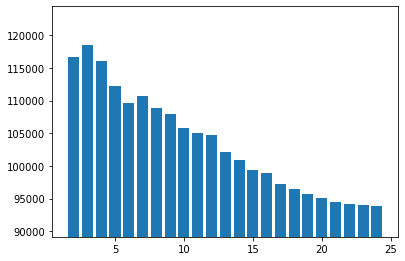

93843.06076388872 103434.00829185125 24


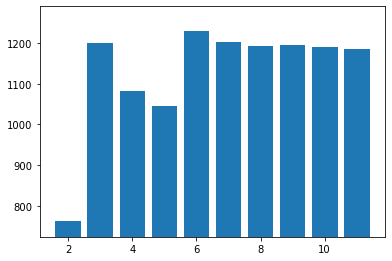

761.6430296614312 1128.466623877947 2


In [46]:
error1 = error_date(df,validation_error_KNN_our,n=25)
show(error1)
print(np.min(error1), np.mean(error1), np.argmin(error1)+2)#the argmin should increment by 2
error2 = error_date(df,validation_error_decision_tree_our,n=12)
show(error2)
print(np.min(error2), np.mean(error2), np.argmin(error2)+2)

Comparing KNN and decision tree in split by region. Similarly, MSE for KNN is very high, and initial prediction for each x_test, the nearest neighbor, is not good. We had better not use KNN for splitting by region. The MSE for decision tree is lower, and the graph shows we had better make a smaller tree(small depth) to make error lower.

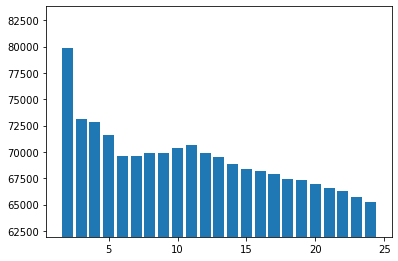

65206.73105709888 69374.70753921456 24 3022.281408283837


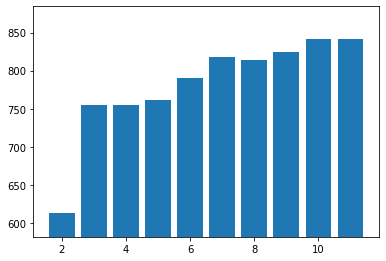

613.0433189565886 781.6064335333788 2 64.66287144436421


In [43]:
error1 = error_region(df,validation_error_KNN_our,n=25)
errorperK1 = np.mean(error1,axis=0)
show(errorperK1)
print(np.min(errorperK1), np.mean(errorperK1), np.argmin(errorperK1)+2, np.std(errorperK1))
error2 = error_region(df,validation_error_decision_tree_our,n=12)
errorperK2 = np.mean(error2,axis=0)
show(errorperK2)
print(np.min(errorperK2), np.mean(errorperK2), np.argmin(errorperK2)+2, np.std(errorperK2))

This is the result that we make a model for each region. MSE and best hyperparameters for each region is shown

In [44]:
print('state           mean error KNN     mean error decision tree    best K')
a = df['region_name'].unique()
for i in a:
    b = df[df['region_name']==i]
    ind1 = np.array(list(range(round(b.shape[0]*0.8))))
    ind2 = np.array(list(range(round(b.shape[0]*0.8),b.shape[0])))
    train = b.to_numpy()[ind1,2:]
    test = b.to_numpy()[ind2,2:]
    x_train, y_train = train[:,1:], train[:,:1]
    x_test, y_test = test[:,1:], test[:,:1]
    error_region_KNN = []
    for K in range(2,15):
        accuracy1 = validation_error_KNN_our(x_train, y_train, x_test, y_test, K)
        error_region_KNN.append(accuracy1)
    error_region_decision_tree = []
    for K in range(2,15):
        accuracy1 = validation_error_decision_tree_our(x_train, y_train, x_test, y_test, K)
        error_region_decision_tree.append(accuracy1)
    j=i
    if(len(i)<6):
        j = i+" "
    print("%s: \t%f \t\t%f \t\t%d" % (j, np.mean(error_region_KNN), np.mean(error_region_decision_tree), np.argmin(error_region_decision_tree)+2))

state           mean error KNN     mean error decision tree    best K
Hawaii: 	17427.470909 		2075.150000 		3
Idaho : 	7414.887392 		2748.492312 		4
Maine : 	126.494510 		46.339421 		2
Montana: 	7904.240516 		1247.565385 		4
North Dakota: 	5833.218102 		811.470085 		2
New Hampshire: 	932.464190 		130.774573 		6
South Dakota: 	28550.616170 		5824.749145 		2
Wyoming: 	154.577342 		3.376998 		5
